In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    Conv1D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout,
    Concatenate,
    Reshape,
    MaxPooling1D,
    GlobalAveragePooling1D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.regularizers import l2  
from tensorflow.keras.optimizers import Adam
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
import matplotlib.pyplot as plt
import pickle
import joblib
from tensorflow.keras import models, layers
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [51]:
# ravdess data
wav_files = 'voice_file/'
ravdess_directory_list = os.listdir(wav_files)

file_emotion = []
file_path = []
temp = []

for dir in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(wav_files, dir))
    for file in actor_files:
        part = file.split('.')[0]
        part = part.split('-')
        temp.append(part)
        file_path.append(wav_files + dir + '/' + file)
    for i in temp:
        if len(i) >= 3:  
            file_emotion.append(int(i[2]))  
        else:
            file_emotion.append(None)
            


path_df = pd.DataFrame(file_path, columns=['path'])
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])
emotion_df.dropna(inplace=True)

ravdess_df = pd.concat([emotion_df, path_df], axis=1)


ravdess_df.emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df['emotion_num'] = file_emotion


ravdess_df.dropna(inplace=True)
ravdess_df['emotions'].value_counts()

calm        192
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
neutral      96
Name: emotions, dtype: int64

In [52]:
dir_list = os.listdir('Savee')

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
    else:
        emotion.append('unknown') 
    path.append('Savee/' + i)

# Now check out the label count distribution 
savee_df = pd.DataFrame(emotion, columns = ['emotions'])
savee_df = pd.concat([savee_df, pd.DataFrame(path, columns = ['path'])], axis = 1)

savee_df['emotion_num'] = emotion
savee_df['emotion_num'].replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5 , 'fear':6, 'disgust':7, 'surprise':8}, inplace=True)

savee_df['emotions'].value_counts()

neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: emotions, dtype: int64

In [53]:
# df = ravdess_df
df = pd.concat([ravdess_df, savee_df], axis=0)
df.reset_index(drop=True, inplace=True)

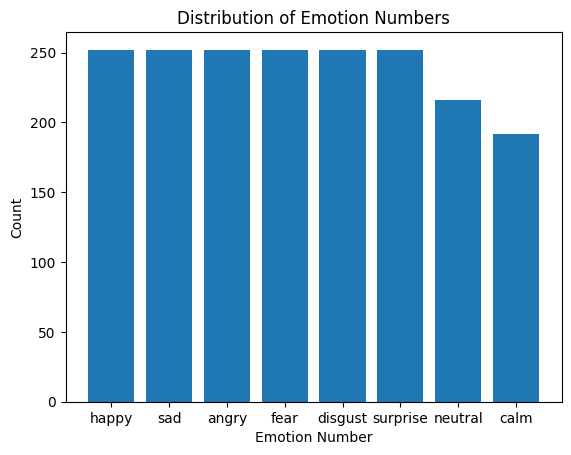

In [54]:
to_plt = df['emotions'].value_counts()

# Plotting
plt.bar(to_plt.index, to_plt.values)

# Adding labels and title
plt.xlabel('Emotion Number')
plt.ylabel('Count')
plt.title('Distribution of Emotion Numbers')

# Display the plot
plt.show()

In [55]:
# Removing surpise 
# df = df.drop(df[df['emotions'] == 'surprise'].index)

# Combining 'calm' into 'neutral'
# df.loc[df['emotions'] == 'calm', 'emotions'] = 'neutral'

df.loc[df['emotion_num'] == 'neutral', 'emotion_num'] = 1

# Setting the emotion numbers to start with 0 
df['emotion_num'] = df['emotion_num'].astype(int)
df['emotion_num'] = df['emotion_num'].apply(lambda x: x - 1)

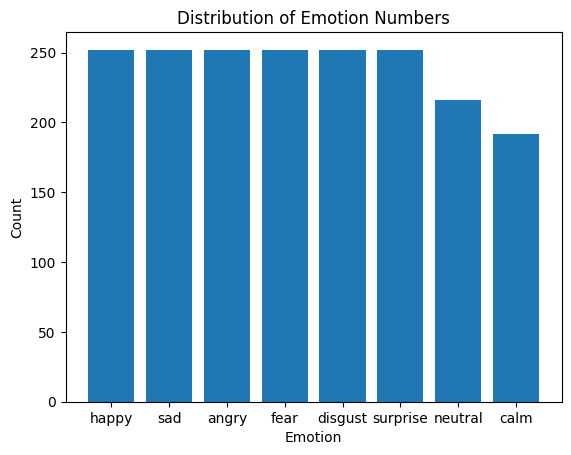

In [56]:
to_plt = df['emotions'].value_counts()
plt.bar(to_plt.index, to_plt.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotion Numbers')
plt.show()

## Functions
## -------------------------------------------------------------------------------------------------------

In [57]:
def padding(array, xx, yy):

    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [58]:
# WORKING GET_FEATURES FUNCTION

def generate_features(y_cut):
    
    max_size=640 
    hop_length = 512 
    n_fft = 255
    sr=28000
    
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length= hop_length)), 128, max_size)
#   MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length,n_mfcc=128),128,max_size)
    MFCCs = padding(librosa.feature.mfcc(y=y_cut),128,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    
    stft = stft.astype(np.float16)
    MFCCs = MFCCs.astype(np.float16)
    spec_centroid = spec_centroid.astype(np.float16)
    chroma_stft = chroma_stft.astype(np.float16)
    spec_bw = spec_bw.astype(np.float16)
    
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    
#repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
        
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [59]:
# def get_features(df_in):   
    
#     features=[]     
#     labels = [] 
            
#     for j in range(len(df_in)):
            
#             emotion_num = df_in.iloc[j]['emotion_num']
#             filename = df_in.iloc[j]['path']
            
#             # Load the file
#             y, sr = librosa.load(filename,sr=28000)  
            
#             #generate features & output numpy array          
#             data = generate_features(y) 
#             features.append(data[np.newaxis,...])    
#             labels.append(emotion_num)  
            
#     output=np.concatenate(features,axis=0)     
#     return(np.array(output), labels)

In [60]:
def get_2d_encoder(input_shape, batch_norm, conv_channels, dropout_prob, pooling, activation, kernel_size, reg_factor):
    """
    Build a 2D convolutional encoder for image-like data (e.g., spectrograms) with regularization.
    
    Parameters:
    - reg_factor (float): L2 regularization factor.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    for layer_conv_ch in conv_channels:
        stride = 1 if pooling else 2
        model.add(Conv2D(layer_conv_ch, kernel_size, padding='same', strides=stride, kernel_regularizer=l2(reg_factor)))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Activation(activation))
        if pooling:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_prob))
    model.add(GlobalAveragePooling2D())
    return model


In [61]:
def get_model(input_shape, batch_norm, conv_channels, dense_widths, dropout_prob, pooling, activation, num_classes, reg_factor):
    """
    Constructs a neural network model for classifying images with regularization.
    
    Parameters:
    - reg_factor (float): L2 regularization factor.
    """
    image_spectograms = Input(shape=input_shape)
    embeddings = get_2d_encoder(
        input_shape=input_shape,
        batch_norm=batch_norm,
        conv_channels=conv_channels,
        dropout_prob=dropout_prob,
        pooling=pooling,
        activation=activation,
        kernel_size=3,
        reg_factor=reg_factor,
    )(image_spectograms)
    x = embeddings
    for units in dense_widths:
        x = Dense(units, activation=activation, kernel_regularizer=l2(reg_factor))(x)
        x = Dropout(dropout_prob)(x)
    output_layer = Dense(num_classes, activation='softmax', kernel_regularizer=l2(reg_factor))(x)
    model = Model(inputs=image_spectograms, outputs=output_layer)
    return model

In [62]:
## NEW FEATURES EXTRACTION

In [63]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

# def rmse(data,frame_length=2048,hop_length=512):
#     rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
#     return np.squeeze(rmse)

# def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
#     mfcc=librosa.feature.mfcc(data)
#     return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
#                       rmse(data,frame_length,hop_length),
                      mfcc(data,sr=sr)
                     ))
    return result

In [64]:
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    return audio

In [65]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(df.path,df.emotions,range(df.path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start) 

17it [00:00, 163.46it/s]

0 audio has been processed


532it [00:03, 155.54it/s]

500 audio has been processed


1019it [00:06, 168.99it/s]

1000 audio has been processed


1517it [00:09, 147.10it/s]

1500 audio has been processed


1920it [00:12, 157.92it/s]

Done
Time:  12.164949300000444


In [71]:
len(X), len(Y)

(4297356, 4297356)

## -----------------------------------------------------------------------------------------------------

## Splitting 

In [76]:
# #Split once to get the test and training set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123)



In [80]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

3223017 3223017 1074339 1074339


In [104]:
X_train_df = X_train.tolist()
X_test_df = X_test.tolist()

X_train_df = pd.DataFrame(X_train_df)
X_test_df = pd.DataFrame(X_test_df)

y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

In [41]:
# #Split twice to get the validation set
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=123)

# print(X_train.shape, X_test.shape, X_val.shape, len(y_train)/total_data, len(y_test)/total_data, len(y_val)/total_data)

(1440, 1) (192, 1) (288, 1) 0.75 0.1 0.15


In [105]:
X_train_df.shape

(3223017, 1)

In [106]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train_cnn and y_train are your training features and labels
# Assuming X_test_cnn and y_test are your testing features and labels

# Initialize the Extra Trees classifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=123)

# Train the classifier
clf.fit(X_train_df, y_train_df)

# Predict the labels for the test set
y_pred = clf.predict(X_test_df)

# Calculate accuracy
accuracy = accuracy_score(y_test_df, y_pred)
print("Accuracy:", accuracy)


MemoryError: could not allocate 469762048 bytes